In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline

# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
from struct import unpack

# https://marcin-chwedczuk.github.io/a-closer-look-at-portable-executable-msdos-stub
MS_DOS_HEADER_FORMAT = '<2b13h8bhh20bl'
# Assembly code to print out the stub
MS_DOS_STUB_FORMAT = '<{:d}b'
# Signature
SIGNATURE_FORMAT = '4s'
# COFF File Header
# [0] & [-1]: multi-class
COFF_FILE_HEADER_FORMAT = '<hhiiihh'
# image optional header
# [0] - 2 classes
# [23] & [24] - multi-class
IMAGE_OPTIONAL_HEADER_STANDARD_FORMAT = '<hbb5i'
MAX_LEN = 4096

def parse_hex(string):
    max_size = len(string)
    if max_size < 64:
        raise Exception('max_size error', max_size)
    
    ms_dos_header = unpack(MS_DOS_HEADER_FORMAT, string[:64])
    pe_sig_start = ms_dos_header[-1]
    pe_sig_end = pe_sig_start + 4

    ms_dos_stub = ()
    if pe_sig_start > 64:
        ms_dos_stub = unpack(MS_DOS_STUB_FORMAT.format(pe_sig_start - 64),
                             string[64:pe_sig_start])
    
    sig = unpack(SIGNATURE_FORMAT, string[pe_sig_start:pe_sig_end])
    
    coff_start = pe_sig_end
    coff_end = pe_sig_end + 20
    coff = unpack(COFF_FILE_HEADER_FORMAT,
                 string[pe_sig_end:coff_end])
    
    optional_header_size = coff[-2]
    img_opt_hdr_start = coff_end
    img_opt_hdr_mid = coff_end + 24
    img_opt_hrd_end = coff_end + optional_header_size
    
    optional_header = ()
    if optional_header_size != 0 and max_size > img_opt_hrd_end:
        optional_header = unpack(IMAGE_OPTIONAL_HEADER_STANDARD_FORMAT,
                                 string[img_opt_hdr_start:img_opt_hdr_mid])
        pe_format = optional_header[0]
        
        # Optional Header Windows-Specific Fields (Image Only)
        if pe_format == 267:
            # format is PE32
            optional_header += unpack('<iiii6h4ihh4iii16q',
                                 string[img_opt_hdr_mid:img_opt_hrd_end])

        elif pe_format == 523:
            # format is PE32+
            optional_header += (np.nan, )
            optional_header += unpack('<qii6h4ihh4qii16q',
                                     string[img_opt_hdr_mid:img_opt_hrd_end])
        else:
            raise Exception('pe_format error', pe_format)
    else:
        raise Exception('coff error', coff)
    
#     number_of_sections = coff[1]
#     section_start = img_opt_hrd_end
#     section_end = img_opt_hrd_end + 40
#     sections = []
#     if max_size > section_end:
#         for sec in range(number_of_sections):
#             sections += [unpack('8s6ihhi', string[section_start:section_end])]
#             section_start = section_end
#             section_end += 40

#     section_data = [max_size, max_size > MAX_LEN] + list(string[section_end:MAX_LEN])

#     return ms_dos_header, ms_dos_stub, sig, coff, optional_header, sections, section_data

section_map = {}
def normalize_pe(parsed):
    global section_map
    max_headers = 26
    N = 4400
    ms_dos_header, ms_dos_stub, sig, coff, optional_header, sections, section_data = parsed
    
    output_sections = []
    for s in sections[:max_headers]:
        key = s[0]
        if not key in section_map:
            section_map[key] = len(section_map)
        output_sections += [section_map[key]] + list(s[1:])
    for i in range(len(sections), max_headers):
        # pad with null
        output_sections += [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    output_sections += [len(sections) > max_headers,]
    
    ms_dos_hash = [0 for i in range(0,256)]
    for x in ms_dos_stub:
        ms_dos_hash[x] += 1

    output = list(ms_dos_header) + ms_dos_hash + list(coff) + list(optional_header) + output_sections + section_data
    output += [0] * (N - len(output))
    return output

In [3]:
train = []
train_label = []

combined = "./data/train_combined.csv"
with open(combined) as combinedcsvfile:
    combinedreader = csv.reader(combinedcsvfile)
    for i, row in enumerate(combinedreader):
        try:
            parsed = parse_hex(bytes([int(x) for x in row[:-1]]))
        except Exception as inst:
            print(i)
            print("Failed to parse: is_malware =", row[-1])
            print(inst.args)
            continue
#         out = normalize_pe(parsed)
#         train += [out]
#         train_label += [row[-1]]

train = pd.DataFrame(train)
train_label = np.array(train_label)
print(train.shape)
print(train_label.shape)
train.to_csv('./data/parsed_train.csv', index=False, header=False)
pd.DataFrame(train_label).to_csv('./data/parsed_labels.csv', index=False, header=False)

4365
Failed to parse: is_malware = 0
('coff error', (332, 5, 1332508402, 0, 0, 224, 271))
63958
Failed to parse: is_malware = 0
('coff error', (332, 4, 1161596910, 0, 0, 224, 259))
65735
Failed to parse: is_malware = 1
('coff error', (332, 3, 1491985532, 0, 0, 224, 258))
69772
Failed to parse: is_malware = 0
('coff error', (332, 5, 1161590502, 0, 0, 224, 259))
71446
Failed to parse: is_malware = 0
('max_size error', 36)
73497
Failed to parse: is_malware = 0
('unpack requires a buffer of 200 bytes',)
77095
Failed to parse: is_malware = 0
('unpack requires a buffer of 216 bytes',)
107337
Failed to parse: is_malware = 0
('unpack requires a buffer of 200 bytes',)
(0, 0)
(0,)


In [3]:
test = []
indexes = []
with open('./data/test.csv') as combinedcsvfile:
    combinedreader = csv.reader(combinedcsvfile)
    for i, row in enumerate(combinedreader):
        try:
            parsed = parse_hex(bytes([int(x) for x in row]))
            out = normalize_pe(parsed)
            test += [out]
            indexes += [1]
        except Exception as inst:
            print("Failed to parse")
            print(inst.args)
            indexes += [0]

pd.DataFrame(indexes).to_csv('./data/parsed_indicies.csv', index=False, header=False)
pd.DataFrame(test).to_csv('./data/parsed_test.csv', index=False, header=False)

Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('coff error', (332, 5, 1468633261, 0, 0, 224, 8450))
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)
Failed to parse
('unpack requires a buffer of 200 bytes',)


In [2]:
TOTAL_ROWS = 113636
ROWS = TOTAL_ROWS

train = pd.read_csv("./parsed_train.csv", nrows=ROWS, header=None)
train_label = pd.read_csv("./parsed_labels.csv", nrows=ROWS, header=None)

assert train.shape[0] == train_label.shape[0], "Train and label shapes are different"

In [3]:
train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399
0,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
1,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
2,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
3,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
4,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
5,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
6,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
7,77,90,64,1,0,2,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
8,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0
9,77,90,144,3,0,4,0,-1,0,184,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mask = np.random.rand(len(train)) < 0.8

x_train = train[mask]
y_train = train_label[mask]
x_test = train[~mask]
y_test = train_label[~mask]

In [5]:
import lightgbm as lgb
import gc
train_data = lgb.Dataset(x_train, label=y_train.values.ravel())

# Create validation data
test_data = train_data.create_valid(x_test, label=y_test.values.ravel())

train = None
x_train = None
y_train = None
x_test = None
y_test = None
gc.collect()

25

In [10]:
params = {
    'learning_rate': 0.025,
    'num_leaves': 51, 
    'lambda_l2': 0.01,
    'objective':'binary',
    'tree_learner': 'voting_parallel',
    'bagging_freq': 10,
    'early_stopping_rounds': 25,
    'top_k': 35,
    'boosting': 'gbdt', # 'gbdt' default
}
num_round = 900
bst = lgb.train(params, 
                train_data, 
                num_round, 
                valid_sets=[test_data], 
#                 init_model='model.txt',
               )
# Save model
bst.save_model('model.txt', num_iteration=bst.best_iteration)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.676802
Training until validation scores don't improve for 35 rounds.
[2]	valid_0's binary_logloss: 0.661077
[3]	valid_0's binary_logloss: 0.645974
[4]	valid_0's binary_logloss: 0.631424
[5]	valid_0's binary_logloss: 0.617421
[6]	valid_0's binary_logloss: 0.603937
[7]	valid_0's binary_logloss: 0.590911
[8]	valid_0's binary_logloss: 0.595605
[9]	valid_0's binary_logloss: 0.582892
[10]	valid_0's binary_logloss: 0.57058
[11]	valid_0's binary_logloss: 0.558654
[12]	valid_0's binary_logloss: 0.562845
[13]	valid_0's binary_logloss: 0.551224
[14]	valid_0's binary_logloss: 0.540003
[15]	valid_0's binary_logloss: 0.529082
[16]	valid_0's binary_logloss: 0.518481
[17]	valid_0's binary_logloss: 0.508239
[18]	valid_0's binary_logloss: 0.498264
[19]	valid_0's binary_logloss: 0.488651
[20]	valid_0's binary_logloss: 0.47929
[21]	valid_0's binary_logloss: 0.481687
[22]	valid_0's binary_logloss: 0.472622
[23]	valid_0's binary_logloss: 0.463752
[24]	valid_0's binary_logloss

[204]	valid_0's binary_logloss: 0.232464
[205]	valid_0's binary_logloss: 0.234006
[206]	valid_0's binary_logloss: 0.231186
[207]	valid_0's binary_logloss: 0.232674
[208]	valid_0's binary_logloss: 0.229928
[209]	valid_0's binary_logloss: 0.231594
[210]	valid_0's binary_logloss: 0.233039
[211]	valid_0's binary_logloss: 0.234496
[212]	valid_0's binary_logloss: 0.231621
[213]	valid_0's binary_logloss: 0.22884
[214]	valid_0's binary_logloss: 0.226138
[215]	valid_0's binary_logloss: 0.223508
[216]	valid_0's binary_logloss: 0.225094
[217]	valid_0's binary_logloss: 0.222534
[218]	valid_0's binary_logloss: 0.219973
[219]	valid_0's binary_logloss: 0.221319
[220]	valid_0's binary_logloss: 0.218788
[221]	valid_0's binary_logloss: 0.220252
[222]	valid_0's binary_logloss: 0.217686
[223]	valid_0's binary_logloss: 0.21517
[224]	valid_0's binary_logloss: 0.216709
[225]	valid_0's binary_logloss: 0.218378
[226]	valid_0's binary_logloss: 0.219728
[227]	valid_0's binary_logloss: 0.220772
[228]	valid_0's bi

[405]	valid_0's binary_logloss: 0.130041
[406]	valid_0's binary_logloss: 0.130575
[407]	valid_0's binary_logloss: 0.129691
[408]	valid_0's binary_logloss: 0.130278
[409]	valid_0's binary_logloss: 0.12945
[410]	valid_0's binary_logloss: 0.128609
[411]	valid_0's binary_logloss: 0.127772
[412]	valid_0's binary_logloss: 0.128298
[413]	valid_0's binary_logloss: 0.128857
[414]	valid_0's binary_logloss: 0.128025
[415]	valid_0's binary_logloss: 0.127212
[416]	valid_0's binary_logloss: 0.126413
[417]	valid_0's binary_logloss: 0.126985
[418]	valid_0's binary_logloss: 0.127541
[419]	valid_0's binary_logloss: 0.126749
[420]	valid_0's binary_logloss: 0.127281
[421]	valid_0's binary_logloss: 0.126507
[422]	valid_0's binary_logloss: 0.12573
[423]	valid_0's binary_logloss: 0.124924
[424]	valid_0's binary_logloss: 0.124165
[425]	valid_0's binary_logloss: 0.12469
[426]	valid_0's binary_logloss: 0.123887
[427]	valid_0's binary_logloss: 0.123115
[428]	valid_0's binary_logloss: 0.123645
[429]	valid_0's bin

[606]	valid_0's binary_logloss: 0.100571
[607]	valid_0's binary_logloss: 0.100795
Early stopping, best iteration is:
[572]	valid_0's binary_logloss: 0.0994197


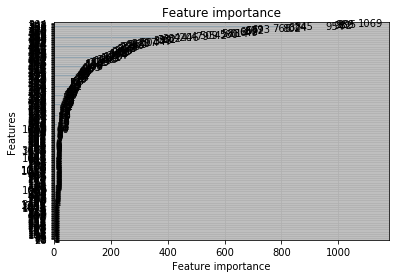

In [11]:
lgb.plot_importance(bst)

In [12]:
TOTAL_ROWS = 133223
ROWS = TOTAL_ROWS
test = pd.read_csv("./parsed_test.csv", nrows=ROWS, header=None)
ypred = bst.predict(test, num_iteration=bst.best_iteration)

df = pd.DataFrame(ypred)
df.to_csv('./predict.csv', index=False, header=False)

In [13]:
import csv

with open('./output.csv', 'w', newline='') as submitcsvfile:
    submitwriter = csv.writer(submitcsvfile)
    submitwriter.writerow(["sample_id", "malware"])
    with open('./predict.csv') as predictcsvfile:
        predictreader = csv.reader(predictcsvfile)
        with open('./parsed_indices.csv') as csvfile:
            rowreader = csv.reader(csvfile)
            for index, row in enumerate(rowreader):
                if row[0] == "0":
                    print(0.875)
                    submitwriter.writerow([index, 0.875])
                else:
                    submitwriter.writerow([index] + predictreader.__next__())

0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875
0.875


In [18]:
feature_indices = bst.feature_name()
feature_importance = bst.feature_importance()

feature_rank = []

for i, index in enumerate(feature_indices):
    importance = feature_importance[i]
    if importance == 0:
        continue
    
    feature_rank.append(int(index))
print(feature_rank)

[2, 3, 6, 7, 20, 25, 26, 27, 28, 45, 46, 52, 53, 54, 56, 62, 65, 66, 67, 68, 73, 76, 78, 81, 82, 83, 85, 87, 88, 91, 93, 94, 95, 96, 97, 99, 101, 102, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 122, 124, 126, 128, 129, 130, 131, 132, 143, 144, 145, 146, 147, 148, 150, 151, 153, 159, 160, 161, 162, 163, 164, 165, 167, 168, 171, 173, 175, 178, 179, 181, 182, 184, 186, 187, 190, 191, 194, 196, 197, 198, 199, 201, 202, 203, 206, 211, 214, 217, 218, 219, 220, 222, 223, 226, 228, 229, 232, 234, 235, 236, 237, 239, 240, 243, 244, 245, 246, 249, 251, 253, 255, 256, 258, 259, 263, 268, 270, 271, 272, 273, 275, 276, 280, 281, 283, 286, 287, 288, 289, 290, 293, 294, 295, 296, 298, 299, 304, 305, 306, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 334, 335, 339, 340, 341, 342, 343, 344, 345, 346, 348, 349, 350, 351, 352, 355, 356, 358, 359, 360, 361, 364, 365, 366, 367, 368, 369, 374, 375, 376, 377, 378, 379, 383, 384,

In [19]:
feature_rank = [2, 3, 6, 7, 20, 25, 26, 27, 28, 45, 46, 52, 53, 54, 56, 62, 65, 66, 67, 68, 73, 76, 78, 81, 82, 83, 85, 87, 88, 91, 93, 94, 95, 96, 97, 99, 101, 102, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 122, 124, 126, 128, 129, 130, 131, 132, 143, 144, 145, 146, 147, 148, 150, 151, 153, 159, 160, 161, 162, 163, 164, 165, 167, 168, 171, 173, 175, 178, 179, 181, 182, 184, 186, 187, 190, 191, 194, 196, 197, 198, 199, 201, 202, 203, 206, 211, 214, 217, 218, 219, 220, 222, 223, 226, 228, 229, 232, 234, 235, 236, 237, 239, 240, 243, 244, 245, 246, 249, 251, 253, 255, 256, 258, 259, 263, 268, 270, 271, 272, 273, 275, 276, 280, 281, 283, 286, 287, 288, 289, 290, 293, 294, 295, 296, 298, 299, 304, 305, 306, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 334, 335, 339, 340, 341, 342, 343, 344, 345, 346, 348, 349, 350, 351, 352, 355, 356, 358, 359, 360, 361, 364, 365, 366, 367, 368, 369, 374, 375, 376, 377, 378, 379, 383, 384, 385, 386, 387, 388, 389, 390, 393, 394, 395, 396, 397, 398, 399, 400, 401, 403, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 417, 418, 419, 424, 425, 426, 427, 428, 429, 434, 435, 436, 437, 438, 439, 444, 445, 446, 447, 448, 457, 616, 618, 620, 634, 646, 654, 656, 657, 658, 660, 666, 683, 687, 694, 695, 702, 703, 707, 715, 718, 791, 796, 802, 937, 942, 943, 944, 950, 958, 962, 964, 966, 967, 968, 971, 974, 975, 977, 978, 983, 985, 986, 988, 990, 1002, 1004, 1015, 1019, 1024, 1048, 1049, 1051, 1086, 1245, 1261, 1338, 3442, 3697]
TOTAL_ROWS = 113636
ROWS = 500

train = pd.read_csv("./parsed_train.csv", nrows=ROWS, usecols=feature_rank, header=None)
train_label = pd.read_csv("./parsed_labels.csv", nrows=ROWS, header=None)

assert train.shape[0] == train_label.shape[0], "Train and label shapes are different"

In [21]:
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

own_embedding_vocab_size = 256

maxlen = x_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=own_embedding_vocab_size, # 10
                    output_dim=32, 
                    input_length=maxlen))
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(Dense(256, activation='elu', activity_regularizer=regularizers.l1_l2(0.0001)))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='elu', activity_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())

model.add(Dense(64, activation='elu', activity_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())

model.add(Dense(32, activation='elu', activity_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001)))

adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])  # Compile the model
print(model.summary())  # Summarize the model

# Path to saved model weights(as hdf5)
filepath = "mlp_model_gbt.h5"
# If exists a best model, load its weights!
if os.path.isfile(filepath):
    print ("Resumed model's weights from {}".format(filepath))
    # load weights
#     model.load_weights(filepath)

checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

another_checkpoint = EarlyStopping(monitor='val_acc', 
                            min_delta=0.001,
                            patience=3, 
                            verbose=1, 
                            mode='auto')

model.fit(x_train, y_train, 
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, another_checkpoint])  # Fit the model

model.save('mlp_model_gbt.h5')

score = model.evaluate(x_test, y_test, verbose=0)  # Evaluate the model
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class Ensemble(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors
        
    def level0_to_level1(self, X):
        self.predictions_ = []

        for regressor in self.regressors:
            self.predictions_.append(regressor.predict(X).reshape(X.shape[0],1))

        return np.concatenate(self.predictions_, axis=1)
    
    def fit(self, X, y):
        for regressor in self.regressors:
            if regressor != nn:
                regressor.fit(X, y)
            else: regressor.fit(X, y, batch_size=64, epochs=1000, verbose=0) # Neural Network
            
        self.new_features = self.level0_to_level1(X)
        
        # using a large L2 regularization to prevent the ensemble from biasing toward 
        # one particular base model
        self.combine = Ridge(alpha=10, max_iter=50000)   
        self.combine.fit(self.new_features, y)

        self.coef_ = self.combine.coef_

    def predict(self, X):
        self.new_features = self.level0_to_level1(X)
            
        return self.combine.predict(self.new_features).reshape(X.shape[0])